In [1]:
"""
Process VIIRS active fire detections output from 03a_viirs_access-swath.ipynb
    - convert to lat/lon points
    - identify adjacent scan duplicates
    - convert to 'pixel ground area'
Author: maxwell.cook@colorado.edu
"""

# Import packages
import sys, os, math
import xarray as xr
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rio

from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
from rasterio.features import rasterize
from tqdm.notebook import tqdm

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Projection information
geog = 'EPSG:4326'  # Geographic projection
prj = 'EPSG:5070'  # Projected coordinate system- WGS 84 NAD83 UTM Zone 13N

# File path information
maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')
# Output directories
dataraw = os.path.join(projdir,'data/spatial/raw/VIIRS/')
datamod = os.path.join(projdir,'data/spatial/mod/VIIRS/')
# Temporary dir for gee exports
tempdir = os.path.join(projdir,'data/earth-engine/imports/temp/')

# File path information
print("Ready !")

Ready !


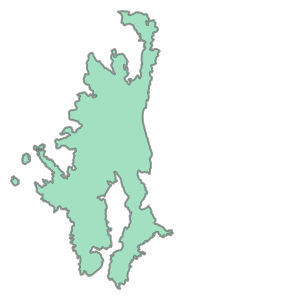

In [2]:
# Southern Rockies ecoregion bounds (buffered)
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_srme.gpkg')
srm = gpd.read_file(fp)
# calculate the total bounds with a 10km buffer
bounds = srm.geometry.unary_union.envelope.buffer(10000) # buffer in m
srm.geometry.unary_union

In [3]:
# Load and tidy the fire perimeter data
## NH: this will be from FIRED now
fp = os.path.join(projdir,'data/spatial/mod/srm_fire_census_2017_to_2023_ics_perims.gpkg')
fires = gpd.read_file(fp)

# tidy the date columns
fires['DISCOVERY_DATE'] = pd.to_datetime(fires['DISCOVERY_DATE'])
fires['WF_CESSATION_DATE'] = pd.to_datetime(fires['WF_CESSATION_DATE'])
fires['Final_Acres'] = fires['Final_Acres'].astype(float)
fires['ICS_ACRES'] = fires['ICS_ACRES'].astype(float)

# subset the columns
## NH: note that FIRED does not have Fire_Name and the columns will be different
fires = fires[['Fire_ID','Fire_Name','Final_Acres',
               'INCIDENT_ID','START_YEAR','DISCOVERY_DATE',
               'WF_CESSATION_DATE','ICS_ACRES','geometry']]

# remove any duplicates (the RYAN fire was duplicated for some reason)
fires = fires.drop_duplicates(subset='INCIDENT_ID', keep='first')

# Add a 3km buffer to wildfire perimeters
buffer_dist = 3000  # meters
# take the convex hull, apply the buffer
fires['geometry'] = fires['geometry'].buffer(buffer_dist)
print(f"Buffered fire perimeters by {buffer_dist} meters.")
print(f"There are {len(fires)} in the Southern Rockies census (2017-2023)")

Buffered fire perimeters by 3000 meters.
There are 114 in the Southern Rockies census (2017-2023)


In [4]:
# load the AFD data from the VIIRS censors
fp = os.path.join(dataraw, 'viirs_snpp_jpss1_afd_.csv')
afds = pd.read_csv(fp).reset_index(drop=True)
afds = afds.loc[:, ~afds.columns.str.startswith('Unnamed:')]
print(f"Number of fire detections: {len(afds)}")
afds.dtypes

Number of fire detections: 3639128


longitude      float64
latitude       float64
fire_mask        int64
confidence      object
frp            float64
t4             float64
t5             float64
m13            float64
acq_date        object
acq_time         int64
daynight        object
satellite       object
short_name      object
granule_id      object
geo_id          object
sample           int64
along_scan     float64
along_track    float64
scan_angle     float64
pix_area       float64
dtype: object

In [5]:
# drop low confidence detections

## NH: potentially keep this step or keep all the fires and allow people to filter after by keeping the confidence column
N = len(afds)
print(afds['confidence'].value_counts())
afds = afds[afds['confidence'] != 'l']
print(f"\nDropped {N-len(afds)} [{round(((N-len(afds))/N)*100,2)}%] low-confidence obs.\n")

confidence
n    3228158
h     212436
l     198534
Name: count, dtype: int64

Dropped 198534 [5.46%] low-confidence obs.



In [6]:
# Create spatial points from lat/lon
from shapely.geometry import Point

# convert to spatial points using pixel centroid
afds['geometry'] = [Point(xy) for xy in zip(afds.longitude, afds.latitude)]
afds_ll = gpd.GeoDataFrame(afds, geometry='geometry', crs="EPSG:4326")
afds_ll = afds_ll.to_crs("EPSG:5070")
afds_ll = afds_ll.reset_index(drop=True)
afds_ll['afdID'] = afds_ll.index # add a unique ID
print(afds_ll[['longitude', 'latitude', 'fire_mask', 'confidence', 'frp', 't4', 't5',
               'm13', 'acq_date', 'acq_time', 'daynight', 'satellite']].head())

# spatially subset the SRM extent
afds_ll = afds_ll[afds_ll.geometry.within(bounds)]
print(f"\n[{len(afds_ll)}({round(len(afds_ll)/len(afds)*100,2)}%)] detections in the Southern Rockies.")

# save this file out.
out_fp = os.path.join(datamod,'viirs_snpp_jpss1_afd_latlon_srm.gpkg')
afds_ll.to_file(out_fp)
print(f"\nSaved spatial points to: {out_fp}\n")

   longitude   latitude  fire_mask confidence        frp         t4  \
0 -95.160160  34.074640          9          h  14.550305  367.00000   
1 -95.164330  34.074383          8          n  14.550305  350.57697   
2 -95.160630  34.080082          8          n   6.089355  343.91302   
3 -95.164825  34.079823          8          n   6.089355  345.46840   
4 -95.906006  34.813230          8          n   4.297072  340.28574   

          t5       m13   acq_date  acq_time daynight satellite  
0  295.69968  2.373925  6/27/2019      2006      Day    JPSS-1  
1  296.18445  2.373925  6/27/2019      2006      Day    JPSS-1  
2  296.12167  1.406672  6/27/2019      2006      Day    JPSS-1  
3  296.05000  1.406672  6/27/2019      2006      Day    JPSS-1  
4  296.18735  1.041121  6/27/2019      2006      Day    JPSS-1  

[169061(4.91%)] detections in the Southern Rockies.

Saved spatial points to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/viirs_snp

In [7]:
# spatially join to the fire perimeters
# retain a subset of fire columns in the join
afds_ll_fires = gpd.sjoin(
    afds_ll, fires[['Fire_ID','Fire_Name','Final_Acres',
                    'DISCOVERY_DATE','WF_CESSATION_DATE',
                    'geometry']], 
    how='inner', 
    predicate='within'
).drop(columns=['index_right']) # drop the join index column

# check for duplicate rows (same AFD, multiple fires)
## NH: removing the smallest duplicate appropriate or is there a better way to handle these VIIRS duplictes?
duplicates = afds_ll_fires[afds_ll_fires.duplicated(subset='afdID', keep=False)]
print(f"\nResolving [{len(duplicates)}/{len(afds_ll_fires)}] duplicate obs.\n")

# create an acquisition datetime column
# set the time in MST as well
# see __functions.py
afds_ll_fires['acq_dt_mst'] = afds_ll_fires.apply(
    lambda row: convert_datetime(
        row['acq_date'], 
        row['acq_time'], 
        zone='America/Denver' # MST
    ), axis=1
)

# tidy & prep the temporal information
afds_ll_fires['acq_date'] = pd.to_datetime(afds_ll_fires['acq_date'])
afds_ll_fires['acq_month'] = afds_ll_fires['acq_date'].dt.month.astype(int) # extract the month
afds_ll_fires['acq_year'] = afds_ll_fires['acq_date'].dt.year.astype(int) # extract the year
# filter the AFDs by temporal matches to their fire event
# identify observations within 14 days of ignition/cessation
afds_ll_fires = afds_ll_fires[
    (afds_ll_fires['acq_date'] >= afds_ll_fires['DISCOVERY_DATE'] - timedelta(days=14)) &
    (afds_ll_fires['acq_date'] <= afds_ll_fires['WF_CESSATION_DATE'] + timedelta(days=14))
]

# re-check duplicates
duplicates = afds_ll_fires[afds_ll_fires.duplicated(subset='afdID', keep=False)]
print(f"\t[{len(duplicates)}] remaining duplicate 'afdID'.\n")
del duplicates
gc.collect()


Resolving [22220/140778] duplicate obs.

	[0] remaining duplicate 'afdID'.



40

In [8]:
# print out the day/night times in MST
day_obs = afds_ll_fires[afds_ll_fires['daynight'] == 'Day']
day_obs['acq_time_mst'] = day_obs['acq_dt_mst'].dt.time
print(f"\nFirst MST datetime for 'Day': {day_obs['acq_time_mst'].min()}")
print(f"Last MST datetime for 'Day': {day_obs['acq_time_mst'].max()}\n")

# check on nighttime datetimes
night_obs = afds_ll_fires[afds_ll_fires['daynight'] == 'Night']
night_obs['acq_time_mst'] = night_obs['acq_dt_mst'].dt.time
print(f"First MST datetime for 'Night': {night_obs['acq_time_mst'].min()}")
print(f"Last MST datetime for 'Night': {night_obs['acq_time_mst'].max()}\n")
del night_obs, day_obs
gc.collect()


First MST datetime for 'Day': 11:54:00
Last MST datetime for 'Day': 15:18:00

First MST datetime for 'Night': 01:06:00
Last MST datetime for 'Night': 04:18:00



62

In [9]:
# handle duplicates caused by the adjacent scan overlap
from scipy.spatial import cKDTree # for distance matrix
# same datetime, distance between detections smaller than the along_track distance
drop_obs = set() # unique detections to drop
# Group observations by Fire_ID and acquisition datetime
dt_groups = afds_ll_fires.groupby(['Fire_ID', 'acq_dt_mst'])
print(f"\nNumber of unique (Fire_ID, acq_datetime) groups: {len(dt_groups)}\n")

# process the datetime groups
def process_afd_duplicates(group):
    """Identify duplicates in a Fire ID/datetime group using KDTree"""
    if len(group) <= 1:
        return  # Skip groups with a single point
    # Extract point coordinates and thresholds
    coords = np.array([[geom.x, geom.y] for geom in group.geometry])
    thresholds = group['along_track'].values / 2 * 1000  # Convert along-track distance to meters
    # Build a KDTree for the group points
    tree = cKDTree(coords)

    # Query KDTree for neighbors within the maximum threshold distance
    for i, (coord, threshold) in enumerate(zip(coords, thresholds)):
        if group.iloc[i]['afdID'] in drop_obs:
            continue  # Skip already marked duplicates
        
        # Find neighbors within the threshold distance
        neighbor_idxs = tree.query_ball_point(coord, threshold)

        # Compare with neighbors and flag duplicates
        for j in neighbor_idxs:
            if i == j or group.iloc[j]['afdID'] in drop_obs:
                continue  # Skip self-comparison and already marked duplicates
            
            # Compare FRP values to determine which detection to drop
            if group.iloc[j]['frp'] < group.iloc[i]['frp']:
                drop_obs.add(group.iloc[j]['afdID'])  # Drop the neighbor
            else:
                drop_obs.add(group.iloc[i]['afdID'])  # Drop the current point
                break  # Stop further checks for this point

# Process each group efficiently
for (fire_id, datetime), group in dt_groups:
    process_afd_duplicates(group)
print(f"Identified [{len(drop_obs)} ({round(len(drop_obs)/len(afds_ll_fires)*100,2)}%)] duplicates.\n")
# Remove duplicates from processing
afds_ll_fires = afds_ll_fires[~afds_ll_fires['afdID'].isin(drop_obs)]
print(f"\t[{len(afds_ll_fires)}] remaining detections.\n")


Number of unique (Fire_ID, acq_datetime) groups: 4255

Identified [11699 (9.15%)] duplicates.

	[116165] remaining detections.




 count    116165.000000
mean      10211.817372
std        8034.542464
min           2.000000
25%        2426.000000
50%        7626.000000
75%       17389.000000
max       22026.000000
Name: count, dtype: float64 

10th percentile count: 1036.0 



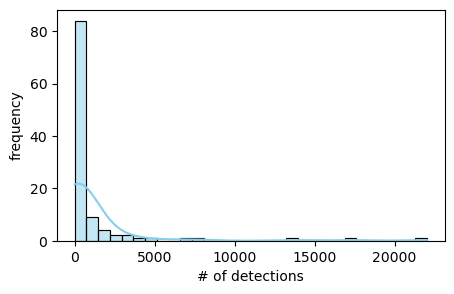

In [10]:
# grab a count of observations for each fire
counts = afds_ll_fires.groupby(['Fire_ID']).size().reset_index(name='count')
afds_ll_fires = pd.merge(afds_ll_fires, counts, on='Fire_ID', how='left')

# print some statistics
print("\n", afds_ll_fires['count'].describe(), "\n")
print(f"10th percentile count: {afds_ll_fires['count'].quantile(0.10)}", "\n") 

# plot the distribution
plt.figure(figsize=(5, 3))  # Set figure size
sns.histplot(counts['count'], bins=30, kde=True, color='skyblue')
plt.xlabel('# of detections', fontsize=10)
plt.ylabel('frequency', fontsize=10)
plt.show()


count    116165.000000
mean         23.536810
std          55.316155
min           0.000000
25%           2.223015
50%           5.731315
75%          18.888193
max        1909.182000
Name: frp, dtype: float64

	Removed [320] observations with FRP == 0


count    115845.000000
mean        107.968118
std         251.654650
min           0.911294
25%          10.646058
50%          26.938382
75%          86.510480
max        8913.220632
Name: frp_wkm2, dtype: float64

        frp   frp_wkm2  pix_area
0  0.933624   6.431219  0.145171
1  1.882405  12.970360  0.145131
2  1.814218  12.497140  0.145171 



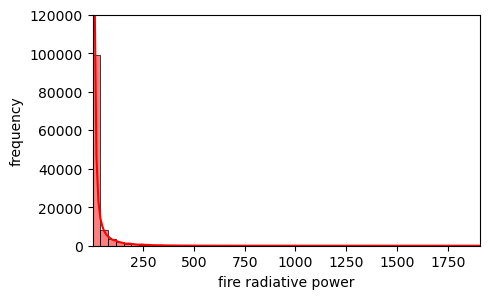

In [11]:
# check on the FRP measurements
# identify observations with 0 FRP
print(f"\n{afds_ll_fires['frp'].describe()}\n")
# drop 0 records (no FRP measurements)
n_zero = afds_ll_fires[afds_ll_fires['frp'] == 0]['frp'].count()
afds_ll_fires = afds_ll_fires[afds_ll_fires['frp'] > 0]
print(f"\tRemoved [{n_zero}] observations with FRP == 0\n")

# create a "W/Km2" column, dividing FRP by pixel area
afds_ll_fires['frp_wkm2'] = afds_ll_fires['frp'] / afds_ll_fires['pix_area']
print(f"\n{afds_ll_fires['frp_wkm2'].describe()}\n")
print(afds_ll_fires[['frp','frp_wkm2','pix_area']].head(3), "\n")

# plot the distribution
x_min, x_max = afds_ll_fires['frp'].min(), afds_ll_fires['frp'].max()
plt.figure(figsize=(5, 3))  # Set figure size
sns.histplot(afds_ll_fires['frp'], bins=50, kde=True, color='red')
plt.xlim(x_min, x_max)
plt.ylim(0, 120000)
plt.xlabel('fire radiative power', fontsize=10)
plt.ylabel('frequency', fontsize=10)
plt.show()

In [12]:
# check on some detections thresholds by fire
print(f">=10 obs: {len(afds_ll_fires[afds_ll_fires['count'] >= 10]['Fire_ID'].unique())}")
print(f">=50 obs: {len(afds_ll_fires[afds_ll_fires['count'] >= 50]['Fire_ID'].unique())}")
print(f">=100 obs: {len(afds_ll_fires[afds_ll_fires['count'] >= 100]['Fire_ID'].unique())}")

>=10 obs: 100
>=50 obs: 69
>=100 obs: 49


In [13]:
# only keep fires with enough detections
n_obs = 10 # the threshold for number of observations
afds_fires = afds_ll_fires[afds_ll_fires['count'] >= n_obs]
print(f"There are {len(afds_fires['Fire_ID'].unique())} fires with >= {n_obs} obs.")

There are 100 fires with >= 10 obs.


In [14]:
# save this file out.
out_fp = os.path.join(datamod,'viirs_snpp_jpss1_afd_latlon_fires.gpkg')
afds_fires.to_file(out_fp)
print(f"Saved spatial points to: {out_fp}")

Saved spatial points to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires.gpkg


In [15]:
# tidy up
del afds_ll_fires, afds_ll
gc.collect()

212

In [16]:
# Create the ground area of pixels based on swath position
# Define the pixel buffer function for the given width and height
def pixel_area(point, width, height):
    half_width = width / 2
    half_height = height / 2
    return box(
        point.x - half_width, point.y - half_height,
        point.x + half_width, point.y + half_height
    )

afds_pix = afds_fires.copy() # work on a copy of our lat/lon detections

# Apply the buffer function with along_scan and along_track values converted to meters (*1000)
afds_pix["geometry"] = afds_pix.apply(
    lambda row: pixel_area(row["geometry"], row["along_scan"] * 1000, row["along_track"] * 1000), axis=1
)

# tidy the index column
afds_pix = afds_pix.reset_index(drop=True)
afds_pix['obs_id'] = afds_pix.index # unique ID column
print(f"Total detections at this stage: {len(afds_pix)}")
print(f"\nColumns available:\n {afds_pix.columns}\n")
afds_pix[['longitude', 'latitude', 'fire_mask', 'confidence', 'frp', 't4', 't5',
          'm13', 'acq_date', 'acq_time', 'acq_dt_mst', 'daynight', 'satellite']].head() # check the results

Total detections at this stage: 115804

Columns available:
 Index(['longitude', 'latitude', 'fire_mask', 'confidence', 'frp', 't4', 't5',
       'm13', 'acq_date', 'acq_time', 'daynight', 'satellite', 'short_name',
       'granule_id', 'geo_id', 'sample', 'along_scan', 'along_track',
       'scan_angle', 'pix_area', 'geometry', 'afdID', 'Fire_ID', 'Fire_Name',
       'Final_Acres', 'DISCOVERY_DATE', 'WF_CESSATION_DATE', 'acq_dt_mst',
       'acq_month', 'acq_year', 'count', 'frp_wkm2', 'obs_id'],
      dtype='object')



,longitude,latitude,fire_mask,confidence,frp,t4,t5,m13,acq_date,acq_time,acq_dt_mst,daynight,satellite
0,-107.124320,40.672466,8,n,0.933624,300.93323,279.65744,0.361779,2017-07-03,906,2017-07-03 03:06:00-06:00,Night,SUOMI-NPP
1,-107.129845,40.669940,8,n,1.882405,310.08480,274.65405,0.423243,2017-07-03,906,2017-07-03 03:06:00-06:00,Night,SUOMI-NPP
2,-107.125320,40.669163,8,n,1.814218,319.54980,285.51047,0.591461,2017-07-03,906,2017-07-03 03:06:00-06:00,Night,SUOMI-NPP
3,-107.126335,40.665860,8,n,1.814218,297.18050,280.36996,0.591461,2017-07-03,906,2017-07-03 03:06:00-06:00,Night,SUOMI-NPP
4,-107.128920,40.664524,8,n,2.538451,305.66788,280.63382,0.712772,2017-07-03,906,2017-07-03 03:06:00-06:00,Night,SUOMI-NPP


In [17]:
# save this file out.
out_fp = os.path.join(datamod,'viirs_snpp_jpss1_afd_latlon_fires_pixar.gpkg')
afds_pix.to_file(out_fp)
print(f"Saved to {out_fp}\n")

Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar.gpkg



In [18]:
# Subset fires to the grid dataset
fires = fires[fires['Fire_ID'].isin(afds_pix['Fire_ID'].unique())]
# export the new fire census
print(f"Exporting {len(fires)}")
out_fp = os.path.join(projdir,'data/spatial/mod/srm_fire_census_2017_to_2023_subset.gpkg')
fires.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Exporting 100
Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/srm_fire_census_2017_to_2023_subset.gpkg


In [19]:
# Aggregate FRP to a regular grid
t0 = time.time()

# create a regular grid extracted to fire perimeters
def regular_grid(extent, res=0.0035, crs_out='EPSG:5070', regions=None):
    """
    Creates a regular-spaced grid
    """
    # retrieve bounding coordinates
    min_lon, max_lon, min_lat, max_lat = extent
    
    # create the grid lines in degrees
    x_coords = np.arange(min_lon, max_lon, res)
    y_coords = np.arange(min_lat, max_lat, res)

    # generate the grid cells
    cells = [
        Polygon([(x, y), (x + res, y), (x + res, y + res), (x, y + res)])
        for x in x_coords for y in y_coords
    ]

    # create a geodataframe in WGS, reprojected if needed
    grid = gpd.GeoDataFrame({'geometry': cells}, crs=crs_out)

    if regions is not None:
        if regions.crs != grid.crs:
            regions = regions.to_crs(grid.crs)
        # Perform spatial intersection to keep only grid cells overlapping the polygon
        grid = grid[grid.intersects(regions.unary_union)].copy()

    return grid

# get the SRM extent in lat/lon (WGS)
coords, extent = get_coords(srm, buffer=1000, crs='EPSG:5070')
print(f"Bounding extent for the SRM: {extent}")

# generate the grid (0.0035 degrees or 375m)
# extract grid intersecting fire perimeters
grid = regular_grid(
    extent, # Southern Rockies
    res=375, # 375m2 (VIIRS at-nadir res)
    crs_out='EPSG:5070', # projected crs
    regions=fires # any overlapping detections
)

# save this out.
out_fp = os.path.join(datamod, 'srm_fire_census_reggrid_375m.gpkg')
grid.to_file(out_fp, driver="GPKG")
print(f"Grid saved to: {out_fp}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.\n")
print("\n~~~~~~~~~~\n")
print("Done!")

Bounding extent for the SRM: [-1184296.5702806395, -692136.0941900016, 1400616.0958773727, 2244339.605203716]
Grid saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/srm_fire_census_reggrid_375m.gpkg

Total elapsed time: 1.25 minutes.


~~~~~~~~~~

Done!


In [20]:
# calculate a gridded cumulative FRP and maximum FRP
# process the fire data by aggregating fractional FRP
t0 = time.time()

def aggregate_frp(detections, grid):
    """
    Aggregate fire pixel frp data into a regular grid with fractional overlay
    """

    # Make sure the projections match
    if detections.crs != grid.crs:
        detections = detections.to_crs(grid.crs)

    # calculate the pixel area in m2
    detections['pix_area_m2'] = detections['pix_area'] * 1e6

    # tidy the grid and calculate the grid area
    grid = grid.reset_index(drop=False).rename(columns={'index': 'grid_index'})
    grid['grid_area'] = grid.geometry.area  # precompute grid cell areas

    # overlay detections onto the grid
    overlay = gpd.overlay(detections, grid, how='intersection')

    # fractional overlap area
    overlay['overlap_m2'] = overlay.geometry.area
    overlay['fraction'] = overlay['overlap_m2'] / overlay['pix_area_m2']
    
    # multiply FRP by fractional area
    overlay['frp_fr'] = overlay['frp_wkm2'] * overlay['fraction']
    overlay['frp_fr'] = overlay['frp_fr'].fillna(0)
    
    # Aggregate by grid cell
    aggregated = overlay.groupby('grid_index').agg(
        afd_count=('frp_fr', 'count'), 
        unique_days=('acq_date', 'nunique'),
        # overlap amount
        overlap=('fraction', 'sum'),
        # fire radiative power
        frp_csum=('frp_fr', 'sum'),
        frp_max=('frp_fr', 'max'),
        frp_min=('frp_fr', 'min'),
        frp_mean=('frp_fr', 'mean'),
        frp_p90=('frp_fr', lambda x: x.quantile(0.90) if not x.empty else 0),
        frp_p95=('frp_fr', lambda x: x.quantile(0.95) if not x.empty else 0),
        frp_p97=('frp_fr', lambda x: x.quantile(0.97) if not x.empty else 0),
        frp_p99=('frp_fr', lambda x: x.quantile(0.99) if not x.empty else 0),
        frp_first=('frp_fr', lambda x: overlay.loc[x.index, :].sort_values('acq_dt_mst').iloc[0]['frp_fr']),
        day_max_frp=('frp_fr', lambda x: overlay.loc[x.idxmax(), 'acq_date'] if not x.empty else None),
        dt_max_frp=('frp_fr', lambda x: overlay.loc[x.idxmax(), 'acq_dt_mst'] if not x.empty else None),
        first_obs_date=('acq_date', 'min'),
        last_obs_date=('acq_date', 'max'),
        # brightness temps
        t4_max=('t4', 'max'),
        t4_mean=('t4', 'mean'),
        t5_max=('t5', 'max'),
        t5_mean=('t5', 'mean') 
    ).reset_index()

    # add day and night FRP stats
    daynight_stats = (
        overlay.groupby(['grid_index', 'daynight'])['frp_fr']
        .agg(
            count='count',
            max='max', 
            mean='mean',
            sum='sum',
            p90=lambda x: x.quantile(0.90) if not x.empty else 0,
            p95=lambda x: x.quantile(0.95) if not x.empty else 0,
            p97=lambda x: x.quantile(0.97) if not x.empty else 0,
            p99=lambda x: x.quantile(0.99) if not x.empty else 0,
            first=lambda x: overlay.loc[x.index, :].sort_values('acq_dt_mst').iloc[0]['frp_fr'],
            last=lambda x: overlay.loc[x.index, :].sort_values('acq_dt_mst', ascending=False).iloc[0]['frp_fr']
        )
        .unstack(fill_value=0)  # Ensure missing values are filled with 0
        .reset_index()
    )

    # Add day/night statistics
    aggregated['day_count'] = daynight_stats['count'].get('Day', 0)
    aggregated['night_count'] = daynight_stats['count'].get('Night', 0)
    aggregated['frp_max_day'] = daynight_stats['max'].get('Day', 0)
    aggregated['frp_max_night'] = daynight_stats['max'].get('Night', 0)
    aggregated['frp_csum_day'] = daynight_stats['sum'].get('Day', 0)
    aggregated['frp_csum_night'] = daynight_stats['sum'].get('Night', 0)
    aggregated['frp_mean_day'] = daynight_stats['mean'].get('Day', 0)
    aggregated['frp_mean_night'] = daynight_stats['mean'].get('Night', 0)
    aggregated['frp_p90_day'] = daynight_stats['p90'].get('Day', 0)
    aggregated['frp_p90_night'] = daynight_stats['p90'].get('Night', 0)
    aggregated['frp_p95_day'] = daynight_stats['p95'].get('Day', 0)
    aggregated['frp_p95_night'] = daynight_stats['p95'].get('Night', 0)
    aggregated['frp_p97_day'] = daynight_stats['p97'].get('Day', 0)
    aggregated['frp_p97_night'] = daynight_stats['p97'].get('Night', 0)
    aggregated['frp_p99_day'] = daynight_stats['p99'].get('Day', 0)
    aggregated['frp_p99_night'] = daynight_stats['p99'].get('Night', 0)
    aggregated['frp_first_day'] = daynight_stats['first'].get('Day', 0)
    aggregated['frp_first_night'] = daynight_stats['first'].get('Night', 0)
    
    # Join results back to grid
    grid = grid.merge(aggregated, on='grid_index', how='right')
        
    return grid


# Make sure we are using fires with >=50 detections
fires_ = fires[fires['Fire_ID'].isin(afds_pix['Fire_ID'].unique())]
fire_grids = [] # Initialize results list
with tqdm(fires_.iterrows(), total=len(fires_)) as pbar:
    for _, fire in pbar:
        pbar.set_description(f"Processing [{fire['Fire_Name']}]")
        # get the geodataframe of the fire
        fire_gdf = gpd.GeoDataFrame([fire], crs=fires_.crs)  # Ensure GeoDataFrame
        
        # aggregate fire pixels to the grid
        fire_grid = aggregate_frp(afds_pix[afds_pix['Fire_ID'] == fire['Fire_ID']], grid)
        fire_grid['Fire_ID'] = fire['Fire_ID']
        fire_grid['Fire_Name'] = fire['Fire_Name']
        fire_grids.append(fire_grid)

# Combine all grids into one
fire_grids = pd.concat(fire_grids)

t3 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t3:.2f} minutes.\n")
print("\n~~~~~~~~~~\n")
print("Done!")

  0%|          | 0/100 [00:00<?, ?it/s]


Total elapsed time: 7.18 minutes.


~~~~~~~~~~

Done!


In [21]:
print(fire_grids['afd_count'].describe())
print("/n")
print(fire_grids['unique_days'].describe())

count    57232.000000
mean        10.424395
std          9.585023
min          1.000000
25%          3.000000
50%          8.000000
75%         14.000000
max        127.000000
Name: afd_count, dtype: float64
/n
count    57232.000000
mean         2.629036
std          2.159976
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         21.000000
Name: unique_days, dtype: float64


In [22]:
fire_grids.sort_values(
    by='frp_csum', ascending=False
)[['grid_index','frp_csum','frp_csum_day','frp_max','frp_max_day',
   'frp_p90', 'frp_p95', 'frp_p97', 'frp_p99','frp_min','frp_first',
   'frp_first_day', 'day_count','night_count']].head(10)

,grid_index,frp_csum,frp_csum_day,frp_max,frp_max_day,frp_p90,frp_p95,frp_p97,frp_p99,frp_min,frp_first,frp_first_day,day_count,night_count
583,1952252,4832.147246,137.104369,3974.643014,96.165512,501.272778,1829.803671,2687.739408,3545.675145,0.381506,0.883894,96.165512,4,10
7300,2083734,4754.565888,4741.164279,4153.693155,4153.693155,211.065592,1987.989914,2854.271210,3720.552507,2.818947,60.951767,60.951767,9,3
4301,2010999,4357.730177,0.000000,4134.826020,0.000000,97.530697,1914.746262,2802.778165,3690.810069,0.003782,3.914322,0.000000,0,12
737,1958998,4312.394386,63.645983,3174.152862,54.924336,904.827019,2039.489941,2493.355109,2947.220278,1.511593,6.695362,7.210054,3,7
85,1986274,3586.602685,3584.354289,3527.881304,3527.881304,1778.431423,2653.156364,3003.046340,3352.936316,1.096108,22.407462,22.407462,4,2
2566,1963783,3561.334090,3558.820128,3077.580711,3077.580711,1775.177120,2426.378915,2686.859633,2947.340352,0.043046,472.773529,472.773529,3,3
778,1984640,3509.955357,2061.742993,876.277730,876.277730,294.821104,658.539640,815.130607,855.895355,0.026187,31.184336,31.184336,14,15
779,1984641,3491.016628,2096.469550,1790.428678,1790.428678,334.111039,868.306273,1237.155235,1606.004197,0.194520,152.517873,17.547271,8,11
580,1952249,3270.576635,0.000000,2976.490438,0.000000,767.197691,1871.844064,2313.702614,2755.561163,0.286664,1.375151,0.000000,0,9
8358,2101604,3221.785712,13.577951,2574.522041,13.577951,1017.110384,1795.816213,2107.298544,2418.780876,2.421777,2.421777,13.577951,1,7


In [23]:
print(f"Cumulative FRP (total): {round(fire_grids['frp_csum'].sum(), 2)} (W/km2)")

Cumulative FRP (total): 12504824.72 (W/km2)


In [24]:
# save this file out.
out_fp = os.path.join(datamod,'viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
fire_grids.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg


In [25]:
fire_grids.columns

Index(['grid_index', 'geometry', 'grid_area', 'afd_count', 'unique_days',
       'overlap', 'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90',
       'frp_p95', 'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp',
       'dt_max_frp', 'first_obs_date', 'last_obs_date', 't4_max', 't4_mean',
       't5_max', 't5_mean', 'day_count', 'night_count', 'frp_max_day',
       'frp_max_night', 'frp_csum_day', 'frp_csum_night', 'frp_mean_day',
       'frp_mean_night', 'frp_p90_day', 'frp_p90_night', 'frp_p95_day',
       'frp_p95_night', 'frp_p97_day', 'frp_p97_night', 'frp_p99_day',
       'frp_p99_night', 'frp_first_day', 'frp_first_night', 'Fire_ID',
       'Fire_Name'],
      dtype='object')

In [26]:
fires.columns

Index(['Fire_ID', 'Fire_Name', 'Final_Acres', 'INCIDENT_ID', 'START_YEAR',
       'DISCOVERY_DATE', 'WF_CESSATION_DATE', 'ICS_ACRES', 'geometry'],
      dtype='object')

In [27]:
# Google Earth Engine exports ...

In [28]:
# Save the pixel ground area data
afds_pix_gee = afds_pix.copy()

# tidy the date columns
afds_pix_gee.rename(columns={
    'DISCOVERY_DATE': 'Ig_Date', 
    'WF_CESSATION_DATE': 'Last_Date'
}, inplace=True)

# convert to string for GEE
date_cols = ['acq_date', 'Ig_Date', 'Last_Date']
for col in date_cols:
    afds_pix_gee[col] = afds_pix_gee[col].dt.date.astype(str)

# subset columns
afds_pix_gee = afds_pix_gee[['Fire_ID','afdID','acq_date','daynight',
                             'Ig_Date','Last_Date','geometry']]
print(afds_pix_gee.dtypes) # make sure the formats are correct

# export shapefile
out_fp = os.path.join(projdir, 'data/earth-engine/imports/viirs_snpp_jpss1_afd_latlon_fires_pixar.zip')
save_zip(afds_pix_gee, out_fp, tempdir) # see __functions.py
print(f"Saved to:{out_fp}")

del afds_pix_gee
gc.collect()

Fire_ID        object
afdID           int64
acq_date       object
daynight       object
Ig_Date        object
Last_Date      object
geometry     geometry
dtype: object
Saved to:/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/viirs_snpp_jpss1_afd_latlon_fires_pixar.zip


66

In [29]:
# also save a fire perimeter dataset for GEE
# subset the fire perimeter data
# fires with >= 50 detections
fires_gee = fires.copy() # work on a copy
fires_gee = fires_gee[fires_gee['Fire_ID'].isin(afds_pix['Fire_ID'].unique())]
print(f"There are {len(fires_gee)} with >= {n_obs} detections.")

# subset columns
fires_gee = fires_gee[['Fire_ID','Fire_Name','START_YEAR',
                       'DISCOVERY_DATE','WF_CESSATION_DATE','geometry']]
fires_gee.rename(columns={
    'START_YEAR': 'Fire_Year', 
    'DISCOVERY_DATE': 'Ig_Date', 
    'WF_CESSATION_DATE': 'Last_Date'
}, inplace=True)
# tidy the date columns
fires_gee['Ig_Date'] = fires_gee['Ig_Date'].dt.date.astype(str)
fires_gee['Last_Date'] = fires_gee['Last_Date'].dt.date.astype(str)

# export the file to a zip archive
out_fp = os.path.join(projdir, 'data/earth-engine/imports/srm_fire_census_w_afds_2017to2023.zip')
save_zip(fires_gee, out_fp, tempdir) # see __functions.py
print(f"\nSaved to:{out_fp}")

There are 100 with >= 10 detections.

Saved to:/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/srm_fire_census_w_afds_2017to2023.zip


In [30]:
# Save the gridstats data for GEE
fire_grids_gee = fire_grids.copy()

# tidy the columns
fire_grids_gee = fire_grids_gee[['grid_index','Fire_ID','afd_count',
                                 'day_max_frp','first_obs_date','last_obs_date',
                                 'geometry']]
fire_grids_gee.rename(columns={
    'day_max_frp': 'max_date', 
    'first_obs_date': 'first_obs', 
    'last_obs_date': 'last_obs'}, inplace=True)
    
# join in the fire ignition dates
fire_grids_gee = fire_grids_gee.merge(fires_gee[['Fire_ID', 'Fire_Year', 'Ig_Date', 'Last_Date']], on='Fire_ID', how='left')

# handle date fields for GEE
date_cols = ['max_date', 'first_obs', 'last_obs', 'Ig_Date', 'Last_Date']
for col in date_cols:
    fire_grids_gee[col] = fire_grids_gee[col].astype(str)

out_fp = os.path.join(projdir,'data/earth-engine/imports/viirs_snpp_jpss1_afd_gridstats.zip')
save_zip(fire_grids_gee, out_fp, tempdir) # see __functions.py
print(f"Exported layer to: {out_fp}")

print(f"\n{fire_grids_gee.head()}\n")

Exported layer to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/viirs_snpp_jpss1_afd_gridstats.zip

   grid_index Fire_ID  afd_count    max_date   first_obs    last_obs  \
0     1955419      16          1  2022-06-16  2022-06-16  2022-06-16   
1     1955420      16          2  2022-06-16  2022-06-14  2022-06-16   
2     1955421      16          4  2022-06-15  2022-06-10  2022-06-15   
3     1955422      16          7  2022-06-15  2022-06-10  2022-06-15   
4     1955423      16          4  2022-06-14  2022-06-10  2022-06-14   

                                            geometry Fire_Year     Ig_Date  \
0  POLYGON ((-858421.570 1463991.096, -858046.570...      2022  2022-04-06   
1  POLYGON ((-858421.570 1464366.096, -858046.570...      2022  2022-04-06   
2  POLYGON ((-858421.570 1464741.096, -858046.570...      2022  2022-04-06   
3  POLYGON ((-858421.570 1465116.096, -858046.570...      2022  2022-04-06   
4  POLYGON ((-858421.570

In [31]:
# Create a dissolved grid by day of first detection for GridMET analysis
# Dissolve by first_obs
grid_gee_dis = fire_grids_gee.dissolve(by=['Fire_ID','first_obs'])
# Reset the index to make `first_obs` a regular column
grid_gee_dis = grid_gee_dis.reset_index()
print(grid_gee_dis.columns)

# Save this file out.
out_fp = os.path.join(projdir,'data/earth-engine/imports/viirs_snpp_jpss1_afd_gridstats_days.zip')
save_zip(grid_gee_dis, out_fp, tempdir) # see __functions.py
print(f"Exported layer to: {out_fp}")

del fire_grids_gee, fires_gee, grid_gee_dis
gc.collect()

Index(['Fire_ID', 'first_obs', 'geometry', 'grid_index', 'afd_count',
       'max_date', 'last_obs', 'Fire_Year', 'Ig_Date', 'Last_Date'],
      dtype='object')
Exported layer to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/viirs_snpp_jpss1_afd_gridstats_days.zip


0

In [32]:
fires.columns

Index(['Fire_ID', 'Fire_Name', 'Final_Acres', 'INCIDENT_ID', 'START_YEAR',
       'DISCOVERY_DATE', 'WF_CESSATION_DATE', 'ICS_ACRES', 'geometry'],
      dtype='object')

In [33]:
# Create the fire bounds for GEE CBI export
bounds = fires.copy()
# Create the bounds with a generous buffer
bounds['geometry'] = bounds.geometry.envelope.buffer(3000)

# Load state boundaries
states = os.path.join(maindir, 'data/boundaries/political/TIGER/tl19_us_states_w_ak_lambert.gpkg')
states = gpd.read_file(states)
states = states.to_crs('EPSG:5070')

# Grab the fire centroid
centroid = bounds.copy()
centroid['geometry'] = centroid.geometry.centroid
fire_state = gpd.overlay(centroid[['Fire_ID','geometry']], states[['STUSPS','geometry']], how='intersection')
fire_state = fire_state[['Fire_ID','STUSPS']]
bounds = pd.merge(bounds, fire_state, on='Fire_ID', how='left')

# Assign the Parks et al. (2019) start and end days
special_case = ['Arizona', 'New Mexico']
bounds['Start_Day'] = None
bounds['End_Day'] = None    
bounds.loc[bounds['STUSPS'].isin(special_case), ['Start_Day', 'End_Day']] = (91, 181)
bounds.loc[~bounds['STUSPS'].isin(special_case), ['Start_Day', 'End_Day']] = (152, 258)
# Tidy the columns for exporting
bounds = bounds[['Fire_ID','Fire_Name','DISCOVERY_DATE','WF_CESSATION_DATE','START_YEAR','Start_Day','End_Day','geometry']]
bounds.rename(columns={
    'START_YEAR': 'Fire_Year',
    'DISCOVERY_DATE': 'Ig_Date',
    'WF_CESSATION_DATE': 'Last_Date'
}, inplace=True)
bounds['Ig_Date'] = bounds['Ig_Date'].dt.date.astype(str)
bounds['Last_Date'] = bounds['Last_Date'].dt.date.astype(str)
print(bounds.head())

# Export to a zipfile
out_fp = os.path.join(projdir,'data/earth-engine/imports/srm_fire_census_2017_to_2023_bounds.zip')
save_zip(bounds, out_fp, tempdir) # see __functions.py
print(f"Exported layer to: {out_fp}")

  Fire_ID                 Fire_Name     Ig_Date   Last_Date Fire_Year  \
0      16  CALF CANYON-HERMITS PEAK  2022-04-06  2022-06-14      2022   
1      48              CAMERON PEAK  2020-08-13  2020-10-17      2020   
2      89          EAST TROUBLESOME  2020-10-14  2020-10-23      2020   
3      90                    MULLEN  2020-09-17  2020-10-08      2020   
4     110              SPRING CREEK  2018-06-27  2018-07-05      2018   

  Start_Day End_Day                                           geometry  
0       152     258  POLYGON ((-864174.742 1425437.251, -864174.742...  
1       152     258  POLYGON ((-836323.213 1973512.067, -836323.213...  
2       152     258  POLYGON ((-870424.136 1940223.461, -870424.136...  
3       152     258  POLYGON ((-876529.011 2032693.362, -876529.011...  
4       152     258  POLYGON ((-818459.577 1629838.059, -818459.577...  
Exported layer to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/srm_fi

In [34]:
gc.collect()

44